### Load Data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
import os
path = 'data'
os.listdir(path)

['test.csv', 'train.csv']

In [3]:
test_df = pd.read_csv(os.path.join(path, 'test.csv'))
train_df = pd.read_csv(os.path.join(path, 'train.csv'))
# fast look at data
print(test_df.head())
print(train_df.head())

   2                                           Great CD  \
0  2  One of the best game music soundtracks - for a...   
1  1                   Batteries died within a year ...   
2  2              works fine, but Maha Energy is better   
3  2                       Great for the non-audiophile   
4  1              DVD Player crapped out after one year   

  My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"  
0  Despite the fact that I have only played a sma...                                                                 

In [4]:
# make correct column names
columns_name = ['polarity', 'title', 'text']
train_df.columns = columns_name
test_df.columns = columns_name


### EDA

In [5]:
# fast look at data
print("Train dataset info:")
print(train_df.info())
print("\nTest dataset info:")
print(test_df.info())



Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   polarity  int64 
 1   title     object
 2   text      object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB
None

Test dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399999 entries, 0 to 399998
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  399999 non-null  int64 
 1   title     399975 non-null  object
 2   text      399999 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB
None


In [6]:
# check missing values
print("\nMissing values in train dataset:")
print(train_df.isnull().sum())
print("\nMissing values in test dataset:") 
print(test_df.isnull().sum())


Missing values in train dataset:
polarity      0
title       207
text          0
dtype: int64

Missing values in test dataset:
polarity     0
title       24
text         0
dtype: int64


In [7]:
# null data should be == "" 
train_df['title'] = train_df['title'].fillna("")
train_df['text'] = train_df['text'].fillna("")
test_df['title'] = test_df['title'].fillna("")
test_df['text'] = test_df['text'].fillna("")

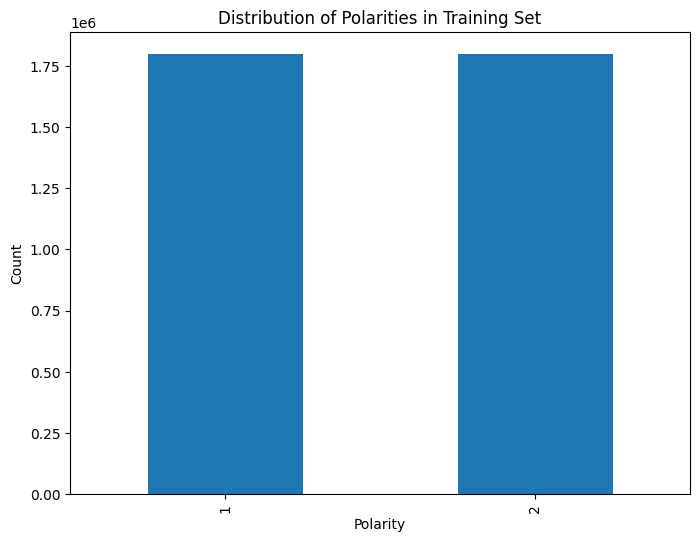

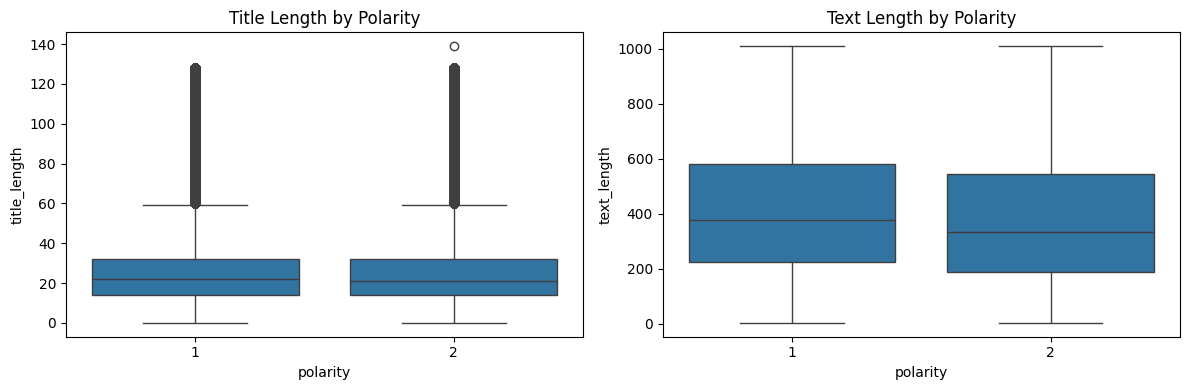


Summary statistics for text lengths:
       title_length   text_length
count  3.599999e+06  3.599999e+06
mean   2.450652e+01  4.051396e+02
std    1.401689e+01  2.342711e+02
min    0.000000e+00  4.000000e+00
25%    1.400000e+01  2.070000e+02
50%    2.100000e+01  3.560000e+02
75%    3.200000e+01  5.660000e+02
max    1.390000e+02  1.010000e+03


In [8]:
plt.figure(figsize=(8,6))
train_df['polarity'].value_counts().plot(kind='bar')
plt.title('Distribution of Polarities in Training Set')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

train_df['title_length'] = train_df['title'].str.len()
train_df['text_length'] = train_df['text'].str.len()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.boxplot(x='polarity', y='title_length', data=train_df)
plt.title('Title Length by Polarity')

plt.subplot(1,2,2)
sns.boxplot(x='polarity', y='text_length', data=train_df)
plt.title('Text Length by Polarity')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary statistics for text lengths:")
print(train_df[['title_length', 'text_length']].describe())

### Data Preprocessing

In [9]:
# Resample data to 20000 samples
sample_size = 10000
train_df = train_df.sample(n=sample_size, random_state=42)

print(f"New training dataset size: {len(train_df)}")
print("\nNew polarity distribution:")
print(train_df['polarity'].value_counts())


New training dataset size: 10000

New polarity distribution:
polarity
1    5024
2    4976
Name: count, dtype: int64


In [10]:
# create a combine title and text
train_df['combined'] = train_df['title'] + " " + train_df['text']
test_df['combined'] = test_df['title'] + " " + test_df['text']
print(train_df['combined'].head())
print(test_df['combined'].head())

3493923    Very disappointed My son got this toy for his ...
2472516    Doesn't help with cats or dogs! A person I wor...
2110064    Don't waste your money on this DVD This DVD is...
2762210    EZEKIEL 13 Mr. Spong has attempted to reduce G...
1438189    Won't fit your case. I am the fourth review an...
Name: combined, dtype: object
0    One of the best game music soundtracks - for a...
1    Batteries died within a year ... I bought this...
2    works fine, but Maha Energy is better Check ou...
3    Great for the non-audiophile Reviewed quite a ...
4    DVD Player crapped out after one year I also b...
Name: combined, dtype: object


In [11]:
from torch.utils.data import Dataset
import torch 
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
max_len = 512 
# create a dataset class
class SMA_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len  

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        text = self.df.iloc[item]['combined']
        polarity = self.df.iloc[item]['polarity']
        
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )
        
        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'polarity': torch.tensor(polarity, dtype=torch.float)  # Adjust dtype as needed
        }

d:\Programs\miniconda\envs\sma\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from torch.utils.data import DataLoader

batch_size = 16
train_dataset = SMA_Dataset(train_df, tokenizer, max_len)
test_dataset = SMA_Dataset(test_df, tokenizer, max_len)

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


### RNN Model initialization

In [28]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
        

In [ ]:
def train_rnn(model, train_dataloader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_dataloader:
            input_ids = batch['input_ids']
            labels = batch['polarity']
            
            input_ids = input_ids.view(-1, input_ids.size(1), param['input_size'])
            
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model


In [ ]:
### init parameters
param = {
    'input_size': 512,
    'hidden_size': 128,
    'output_size': 3,
    'num_layers': 1
}

num_epochs = 10
batch_size = 32

model = RNNModel(**param)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
model = train_rnn(model, train_dataloader, criterion, optimizer, num_epochs)

RuntimeError: shape '[-1, 512, 512]' is invalid for input of size 16384